In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Name: Noam Marko

ID: 205684921

Kaggle_User: https://www.kaggle.com/noammarko

## Exp:
In this competition we need to build a modle that will predict for us which of the passengers survived the Titanic shipwreck with minimum error using the given data.
We will clean the features and drop irrelevant information so we will have an easier time using the data to our benefit. 
In addition of cleaning and dropping features, we might add new features that we can find useful to the prediction of the survival of the passenger.
Afterwards we will create graphs and plots of the features to help us understand the connection between features, and if we have another combination of features that we can use.
At the end of the notebook we will use different kind of modles (SGD, MLP etc.) and compair the results we got from the different modles.

In [2]:
#sklearn import
import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn import pipeline, preprocessing
from sklearn import neural_network
#different kind of imports
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

full_data = pd.concat([train_df, test_df], sort = True).reset_index(drop = True)
full_data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


# Creating new features that might help in the future.
# Filling all Nan cells
# Replacing all the data to be numeric

In [3]:
# Splitting the 'Sex' column into 'Men' and 'Women' columns. 
full_data['Sex'] = full_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
full_data['Men'] = full_data['Sex'].map( {0: 0, 1: 1} ).astype(int)
full_data['Women'] = full_data['Sex'].map( {0: 1, 1: 0} ).astype(int)

# filling in the mean of the 'Age' column to every null cell. Doing the same to the 'Fare' column
full_data['Age'] = full_data['Age'].fillna(full_data['Age'].mean())
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].mean())

# Creating a new feature - 'FamilySize', if the size of the cell = 1 the passenger is alone
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1 # 1 to add the person himself to the size of the family


# Replacing all empty cells with 'S' and then performing one-hot encoding.
full_data['Embarked'] = full_data['Embarked'].fillna('S')
one_hot = pd.get_dummies(full_data['Embarked'], prefix='Embarked')
full_data = full_data.join(one_hot)


#One-hot encoding for Pclass
one_hot = pd.get_dummies(full_data['Pclass'], prefix='Pclass')
full_data = full_data.join(one_hot)

full_data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.000000,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,...,A/5 21171,1,0,2,0,0,1,0,0,1
1,38.000000,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,PC 17599,0,1,2,1,0,0,1,0,0
2,26.000000,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,...,STON/O2. 3101282,0,1,1,0,0,1,0,0,1
3,35.000000,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,113803,0,1,2,0,0,1,1,0,0
4,35.000000,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,...,373450,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.881138,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,1,0,...,A.5. 3236,1,0,1,0,0,1,0,0,1
1305,39.000000,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,0,0,...,PC 17758,0,1,1,1,0,0,1,0,0
1306,38.500000,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,1,0,...,SOTON/O.Q. 3101262,1,0,1,0,0,1,0,0,1
1307,29.881138,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,1,0,...,359309,1,0,1,0,0,1,0,0,1


# Creating new feature
This next piece of code has been taken from the notebook https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#2.-Feature-Engineering

It clasiffies the passengers into sections (decks, most passengers have a Cabin number that has a letter followed by numbers. The letter is the section, or deck if you will, that the passenger is in). This feature indicates where is the area of the passenger and might help us predict if the passenger survived.

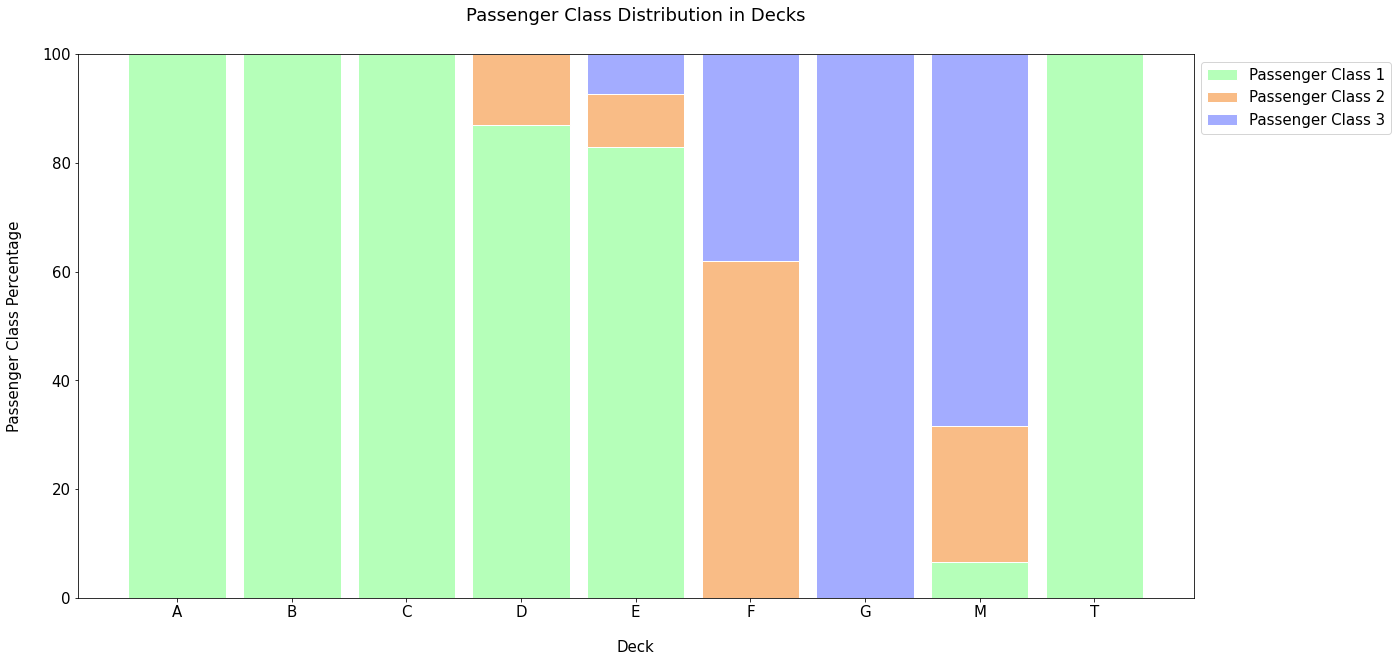

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [4]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
full_data['Deck'] = full_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = full_data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)
idx = full_data[full_data['Deck'] == 'T'].index
full_data.loc[idx, 'Deck'] = 'A'
full_data['Deck'] = full_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
full_data['Deck'] = full_data['Deck'].replace(['D', 'E'], 'DE')
full_data['Deck'] = full_data['Deck'].replace(['F', 'G'], 'FG')

full_data['Deck'].value_counts()

# Analysis
As we can see from the chart above, the passengers that are on deck A, B and C are all from Class 1, M stands for missing (i.e has no Cabin number). Every other deck is mixed with different passengers from different classes. Deck G has only 3rd class passengers, and deck T has one passenger from Class 1, so we combine between Deck T and A.

# We'll perform one-hot encoding to the 'Deck' column, like we did to 'Embarked' and 'Pclass'

In [5]:
one_hot = pd.get_dummies(full_data['Deck'], prefix='Deck')
full_data = full_data.join(one_hot)
display(full_data)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck,Deck_ABC,Deck_DE,Deck_FG,Deck_M
0,22.000000,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,...,0,1,0,0,1,M,0,0,0,1
1,38.000000,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,0,0,1,0,0,ABC,1,0,0,0
2,26.000000,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,...,0,1,0,0,1,M,0,0,0,1
3,35.000000,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,0,1,1,0,0,ABC,1,0,0,0
4,35.000000,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,...,0,1,0,0,1,M,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.881138,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,1,0,...,0,1,0,0,1,M,0,0,0,1
1305,39.000000,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,0,0,...,0,0,1,0,0,ABC,1,0,0,0
1306,38.500000,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,1,0,...,0,1,0,0,1,M,0,0,0,1
1307,29.881138,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,1,0,...,0,1,0,0,1,M,0,0,0,1


# Now that we have all the passengers and which deck they are in, we can create boolian variables to help us predict the survival of the passengers.

# Splitting the data back to test and train and dropping irrelevant columns.

In [6]:
train_df, test_df = full_data.loc[:890], full_data.loc[891:].drop(['Survived'], axis = 1)

In [7]:
passenger_test_col = test_df['PassengerId'].copy(deep=True)

drop_elements = ['PassengerId', 'Name', 'Embarked', 'Ticket', 'Cabin', 'Deck']
train_df = train_df.drop(drop_elements, axis = 1)
test_df = test_df.drop(drop_elements, axis = 1)

In [8]:
train_df

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
0,22.000000,7.2500,0,3,1,1,0.0,1,0,2,0,0,1,0,0,1,0,0,0,1
1,38.000000,71.2833,0,1,0,1,1.0,0,1,2,1,0,0,1,0,0,1,0,0,0
2,26.000000,7.9250,0,3,0,0,1.0,0,1,1,0,0,1,0,0,1,0,0,0,1
3,35.000000,53.1000,0,1,0,1,1.0,0,1,2,0,0,1,1,0,0,1,0,0,0
4,35.000000,8.0500,0,3,1,0,0.0,1,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,13.0000,0,2,1,0,0.0,1,0,1,0,0,1,0,1,0,0,0,0,1
887,19.000000,30.0000,0,1,0,0,1.0,0,1,1,0,0,1,1,0,0,1,0,0,0
888,29.881138,23.4500,2,3,0,1,0.0,0,1,4,0,0,1,0,0,1,0,0,0,1
889,26.000000,30.0000,0,1,1,0,1.0,1,0,1,1,0,0,1,0,0,1,0,0,0


# Creating a graph to show the connection between survival and family size

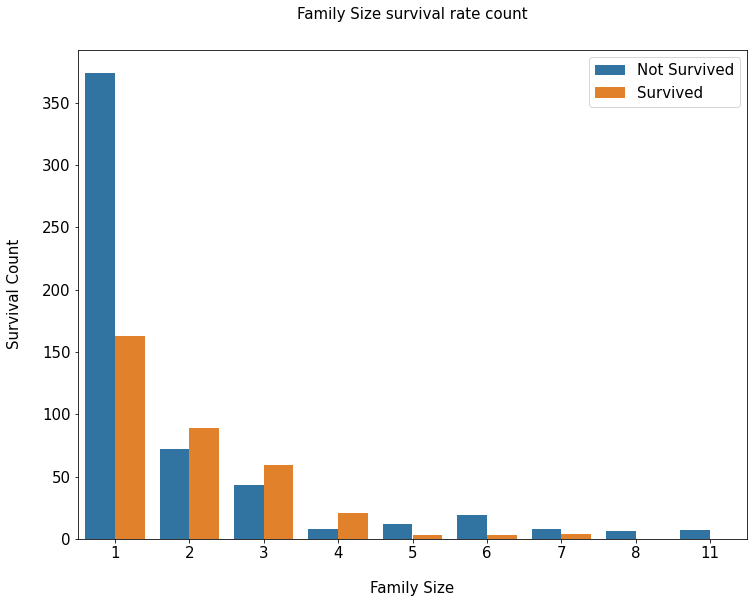

In [9]:
fig, axs = plt.subplots(figsize=(12, 9))

sea.countplot(x='FamilySize', hue='Survived', data=train_df)

plt.xlabel('Family Size', size=15, labelpad=20)
plt.ylabel('Survival Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Family Size survival rate count', size=15, y=1.05)

plt.show()


# As we can clearly see, passengers with family size between 2 and 4 had a better survival precentage. 

In [10]:
test_df

,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
891,34.500000,7.8292,0,3,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1
892,47.000000,7.0000,0,3,0,1,0,1,2,0,0,1,0,0,1,0,0,0,1
893,62.000000,9.6875,0,2,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1
894,27.000000,8.6625,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
895,22.000000,12.2875,1,3,0,1,0,1,3,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.881138,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
1305,39.000000,108.9000,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0
1306,38.500000,7.2500,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
1307,29.881138,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1


# Checking for any NULL columns

In [11]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
display_missing(train_df)
display_missing(test_df)
    

Age column missing values: 0
Fare column missing values: 0
Parch column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Men column missing values: 0
Women column missing values: 0
FamilySize column missing values: 0
Embarked_C column missing values: 0
Embarked_Q column missing values: 0
Embarked_S column missing values: 0
Pclass_1 column missing values: 0
Pclass_2 column missing values: 0
Pclass_3 column missing values: 0
Deck_ABC column missing values: 0
Deck_DE column missing values: 0
Deck_FG column missing values: 0
Deck_M column missing values: 0


Age column missing values: 0
Fare column missing values: 0
Parch column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Men column missing values: 0
Women column missing values: 0
FamilySize column missing values: 0
Embarked_C column missing values: 0
Embarked_Q column missing valu

# Heat Map 

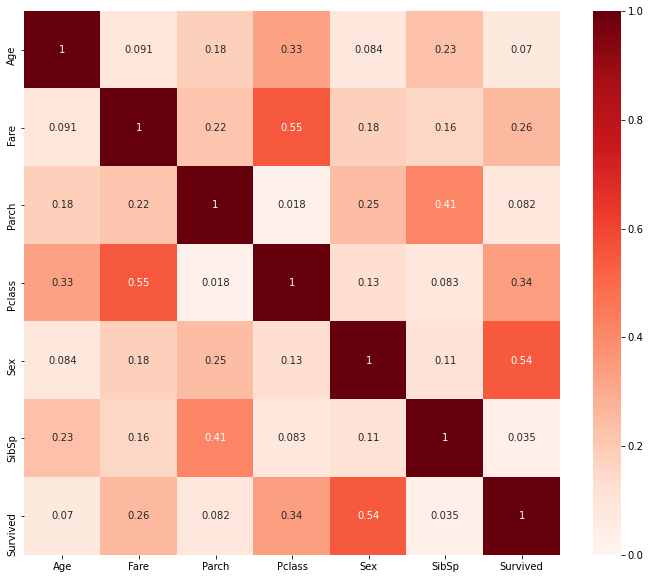

In [12]:
df = train_df.copy(deep=True)
drop_elem = ['Embarked_S', 'Embarked_C', 'Embarked_Q', 'Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_M', 'Men', 'Women', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'FamilySize']
df = df.drop(drop_elem, axis = 1)
plt.figure(figsize=(12,10))
cor = np.abs(df.corr())
sea.heatmap(cor, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.show()

# Analysis
We can understand from this plot that not too many features are correlated with one another. This means that most of our data in the traning set is uniqe.

# Now we will create a pairolot, for the purpose of finding out if there is distribution of data from one feature to another.

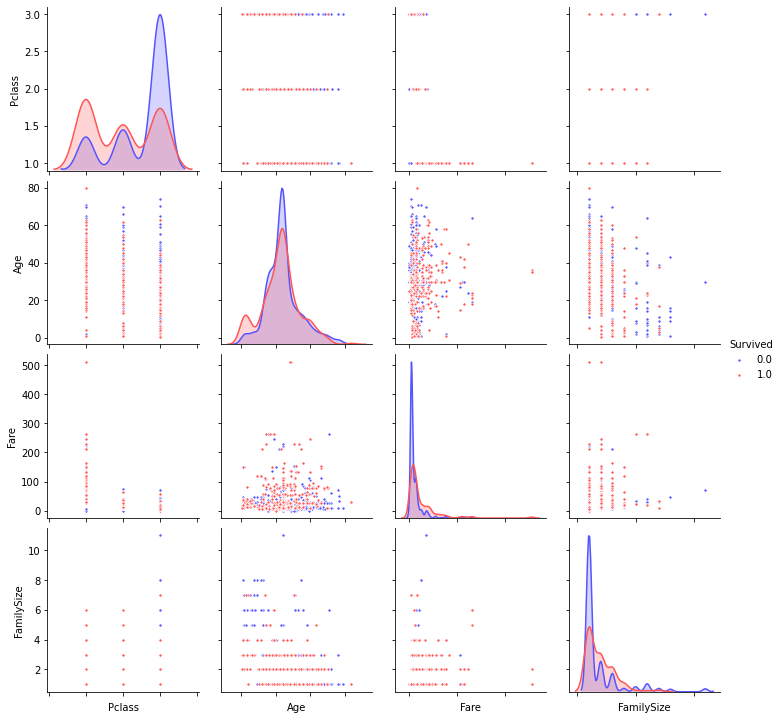

In [13]:
pair = sea.pairplot(train_df[[u'Survived', u'Pclass', u'Age', u'Fare',
       u'FamilySize']], hue = 'Survived', palette = 'seismic',
                   height = 2.5, diag_kind = 'kde', diag_kws = dict(shade = True),
                    plot_kws = dict (s=10))
pair.set(xticklabels=[])

# Analysis 
According to the pairplot we performed, it seems like more passengers survived the shipwreck rather than didn't survive. I beleive the reason it SEEMS this way is because the red dots (survived) and the blue dots (didn't survive) are mixed up together and we can't see the clear picture.

# Now we'll split the train data, and use different modles to determine which one gives us the best result.

In [14]:
temp_df = train_df.copy(deep=True)
t = temp_df['Survived']
x = temp_df.drop('Survived', axis = 1)

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=0.2, random_state=2)
print('X_train')
display(X_train)
print()
print('t_train')
display(t_train)
print()
print('X_test')
display(X_test)
print()
print('t_test')
display(t_test)

X_train


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
30,40.000000,27.7208,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1
10,4.000000,16.7000,1,3,0,1,0,1,3,0,0,1,0,0,1,0,0,1,0
873,47.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
182,9.000000,31.3875,2,3,1,4,1,0,7,0,0,1,0,0,1,0,0,0,1
876,20.000000,9.8458,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,30.000000,8.6625,0,3,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1
584,29.881138,8.7125,0,3,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1
493,71.000000,49.5042,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1
527,29.881138,221.7792,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0



t_train


30     0.0
10     1.0
873    0.0
182    0.0
876    0.0
      ... 
534    0.0
584    0.0
493    0.0
527    0.0
168    0.0
Name: Survived, Length: 712, dtype: float64


X_test


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
707,42.000000,26.2875,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0
37,21.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
615,24.000000,65.0000,2,2,0,1,0,1,4,0,0,1,0,1,0,0,0,0,1
169,28.000000,56.4958,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
68,17.000000,7.9250,2,3,0,4,0,1,7,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,24.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
80,22.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1
846,29.881138,69.5500,2,3,1,8,1,0,11,0,0,1,0,0,1,0,0,0,1
870,26.000000,7.8958,0,3,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1



t_test


707    1.0
37     0.0
615    1.0
169    0.0
68     1.0
      ... 
89     0.0
80     0.0
846    0.0
870    0.0
251    0.0
Name: Survived, Length: 179, dtype: float64

# We'll try to predict who survived based on our datasets and features.

In [15]:
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
y_train_prob = SGD_cls.predict_proba(X_train)
y_test_prob = SGD_cls.predict_proba(X_test)
y_train = SGD_cls.predict(X_train)
y_test = SGD_cls.predict(X_test)
print('first 5 probabilities of y_train_prob:')
print(y_train_prob[:5])
print()
print('first 5 predictions of y_train:')
print(y_train[:5])
print()
print('first 5 probabilities of y_test_prob:')
print(y_test_prob[:5])
print()
print('first 5 predictions of y_test:')
print(y_test[:5])

first 5 probabilities of y_train_prob:
[[0.79326396 0.20673604]
 [0.14408375 0.85591625]
 [0.96858115 0.03141885]
 [0.94914545 0.05085455]
 [0.88815347 0.11184653]]

first 5 predictions of y_train:
[0. 1. 0. 0. 0.]

first 5 probabilities of y_test_prob:
[[0.62727117 0.37272883]
 [0.89354831 0.10645169]
 [0.16584918 0.83415082]
 [0.91167305 0.08832695]
 [0.60221116 0.39778884]]

first 5 predictions of y_test:
[0. 0. 1. 0. 0.]


In [16]:
print('Accuracy score on train', SGD_cls.score(X_train, t_train))
print('Accuracy score on test', SGD_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.8117977528089888
Accuracy score on test 0.776536312849162

CE on train 0.42047606365273615
CE on test 0.5149394305842125


# As we see our accuracy is decent, yet our CE isn't as low as we hoped for.

# Different kind of modle is the neural network

In [17]:
MLP_cls = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(X_train, t_train)
y_train_prob = MLP_cls.predict_proba(X_train)
y_test_prob = MLP_cls.predict_proba(X_test)
print('Accuracy score on train', MLP_cls.score(X_train, t_train))
print('Accuracy score on test', MLP_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.7921348314606742
Accuracy score on test 0.7541899441340782

CE on train 0.42759187955636946
CE on test 0.5043018628367386


# Comparison
Comparing the two modles (Neural Network vs. SGD), we can see we get better accuracy using SGD.

# Now we'll take out some features, to see whether or not they were helpful in predicting who survived the titanic

In [18]:
temp2_df = train_df.copy(deep = True)
t = temp2_df['Survived']
elem_drop = ['Survived','Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_M']
x = temp2_df.drop(elem_drop, axis = 1)

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=0.2, random_state=2)
print('X_train')
display(X_train)
print()
print('t_train')
display(t_train)
print()
print('X_test')
display(X_test)
print()
print('t_test')
display(t_test)

X_train


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
30,40.000000,27.7208,0,1,1,0,1,0,1,1,0,0,1,0,0
10,4.000000,16.7000,1,3,0,1,0,1,3,0,0,1,0,0,1
873,47.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,1
182,9.000000,31.3875,2,3,1,4,1,0,7,0,0,1,0,0,1
876,20.000000,9.8458,0,3,1,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,30.000000,8.6625,0,3,0,0,0,1,1,0,0,1,0,0,1
584,29.881138,8.7125,0,3,1,0,1,0,1,1,0,0,0,0,1
493,71.000000,49.5042,0,1,1,0,1,0,1,1,0,0,1,0,0
527,29.881138,221.7792,0,1,1,0,1,0,1,0,0,1,1,0,0



t_train


30     0.0
10     1.0
873    0.0
182    0.0
876    0.0
      ... 
534    0.0
584    0.0
493    0.0
527    0.0
168    0.0
Name: Survived, Length: 712, dtype: float64


X_test


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
707,42.000000,26.2875,0,1,1,0,1,0,1,0,0,1,1,0,0
37,21.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1
615,24.000000,65.0000,2,2,0,1,0,1,4,0,0,1,0,1,0
169,28.000000,56.4958,0,3,1,0,1,0,1,0,0,1,0,0,1
68,17.000000,7.9250,2,3,0,4,0,1,7,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,24.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,1
80,22.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,1
846,29.881138,69.5500,2,3,1,8,1,0,11,0,0,1,0,0,1
870,26.000000,7.8958,0,3,1,0,1,0,1,0,0,1,0,0,1



t_test


707    1.0
37     0.0
615    1.0
169    0.0
68     1.0
      ... 
89     0.0
80     0.0
846    0.0
870    0.0
251    0.0
Name: Survived, Length: 179, dtype: float64

In [19]:
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
y_train_prob = SGD_cls.predict_proba(X_train)
y_test_prob = SGD_cls.predict_proba(X_test)
y_train = SGD_cls.predict(X_train)
y_test = SGD_cls.predict(X_test)
print('first 5 probabilities of y_train_prob:')
print(y_train_prob[:5])
print()
print('first 5 predictions of y_train:')
print(y_train[:5])
print()
print('first 5 probabilities of y_test_prob:')
print(y_test_prob[:5])
print()
print('first 5 predictions of y_test:')
print(y_test[:5])

first 5 probabilities of y_train_prob:
[[0.62625071 0.37374929]
 [0.20916476 0.79083524]
 [0.96631503 0.03368497]
 [0.94982184 0.05017816]
 [0.89044316 0.10955684]]

first 5 predictions of y_train:
[0. 1. 0. 0. 0.]

first 5 probabilities of y_test_prob:
[[0.73981228 0.26018772]
 [0.89544093 0.10455907]
 [0.15734332 0.84265668]
 [0.91057467 0.08942533]
 [0.59378179 0.40621821]]

first 5 predictions of y_test:
[0. 0. 1. 0. 0.]


In [20]:
print('Accuracy score on train', SGD_cls.score(X_train, t_train))
print('Accuracy score on test', SGD_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.8117977528089888
Accuracy score on test 0.7597765363128491

CE on train 0.42687955038649705
CE on test 0.5157102097769289


# Side note 
As we can see, after dropping the features that with them we can tell where on the Titanic the passengers where staying we got a really close result to the one where we included those features. Thus, we understand that those features didn't help us predict any better which passenger survived.

In [21]:
MLP_cls = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(X_train, t_train)
y_train_prob = MLP_cls.predict_proba(X_train)
y_test_prob = MLP_cls.predict_proba(X_test)
print('Accuracy score on train', MLP_cls.score(X_train, t_train))
print('Accuracy score on test', MLP_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.8160112359550562
Accuracy score on test 0.776536312849162

CE on train 0.4209320356938582
CE on test 0.5131984405096809


# Let us check if any other features were relevant to our prediction

In [22]:
temp3_df = train_df.copy(deep = True)
t = temp3_df['Survived']
elem_drop = ['Survived','Embarked_S', 'Embarked_C', 'Embarked_Q']
x = temp3_df.drop(elem_drop, axis = 1)

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=0.2, random_state=2)
print('X_train')
display(X_train)
print()
print('t_train')
display(t_train)
print()
print('X_test')
display(X_test)
print()
print('t_test')
display(t_test)

X_train


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
30,40.000000,27.7208,0,1,1,0,1,0,1,1,0,0,0,0,0,1
10,4.000000,16.7000,1,3,0,1,0,1,3,0,0,1,0,0,1,0
873,47.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,0,1
182,9.000000,31.3875,2,3,1,4,1,0,7,0,0,1,0,0,0,1
876,20.000000,9.8458,0,3,1,0,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,30.000000,8.6625,0,3,0,0,0,1,1,0,0,1,0,0,0,1
584,29.881138,8.7125,0,3,1,0,1,0,1,0,0,1,0,0,0,1
493,71.000000,49.5042,0,1,1,0,1,0,1,1,0,0,0,0,0,1
527,29.881138,221.7792,0,1,1,0,1,0,1,1,0,0,1,0,0,0



t_train


30     0.0
10     1.0
873    0.0
182    0.0
876    0.0
      ... 
534    0.0
584    0.0
493    0.0
527    0.0
168    0.0
Name: Survived, Length: 712, dtype: float64


X_test


,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
707,42.000000,26.2875,0,1,1,0,1,0,1,1,0,0,0,1,0,0
37,21.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,0,1
615,24.000000,65.0000,2,2,0,1,0,1,4,0,1,0,0,0,0,1
169,28.000000,56.4958,0,3,1,0,1,0,1,0,0,1,0,0,0,1
68,17.000000,7.9250,2,3,0,4,0,1,7,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,24.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,0,1
80,22.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,0,1
846,29.881138,69.5500,2,3,1,8,1,0,11,0,0,1,0,0,0,1
870,26.000000,7.8958,0,3,1,0,1,0,1,0,0,1,0,0,0,1



t_test


707    1.0
37     0.0
615    1.0
169    0.0
68     1.0
      ... 
89     0.0
80     0.0
846    0.0
870    0.0
251    0.0
Name: Survived, Length: 179, dtype: float64

In [23]:
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
y_train_prob = SGD_cls.predict_proba(X_train)
y_test_prob = SGD_cls.predict_proba(X_test)
y_train = SGD_cls.predict(X_train)
y_test = SGD_cls.predict(X_test)
print('first 5 probabilities of y_train_prob:')
print(y_train_prob[:5])
print()
print('first 5 predictions of y_train:')
print(y_train[:5])
print()
print('first 5 probabilities of y_test_prob:')
print(y_test_prob[:5])
print()
print('first 5 predictions of y_test:')
print(y_test[:5])

first 5 probabilities of y_train_prob:
[[0.78932435 0.21067565]
 [0.16081915 0.83918085]
 [0.96333628 0.03666372]
 [0.95002294 0.04997706]
 [0.8628733  0.1371267 ]]

first 5 predictions of y_train:
[0. 1. 0. 0. 0.]

first 5 probabilities of y_test_prob:
[[0.49160425 0.50839575]
 [0.86977882 0.13022118]
 [0.19131219 0.80868781]
 [0.88939481 0.11060519]
 [0.6762099  0.3237901 ]]

first 5 predictions of y_test:
[1. 0. 1. 0. 0.]


In [24]:
print('Accuracy score on train', SGD_cls.score(X_train, t_train))
print('Accuracy score on test', SGD_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.8188202247191011
Accuracy score on test 0.7988826815642458

CE on train 0.4196569964027773
CE on test 0.5084362065583354


In [25]:
MLP_cls = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(X_train, t_train)
y_train_prob = MLP_cls.predict_proba(X_train)
y_test_prob = MLP_cls.predict_proba(X_test)
print('Accuracy score on train', MLP_cls.score(X_train, t_train))
print('Accuracy score on test', MLP_cls.score(X_test, t_test))
print()
print('CE on train', metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.800561797752809
Accuracy score on test 0.770949720670391

CE on train 0.4281674003918526
CE on test 0.5062852665722568


# Summary
After all the modle testing, we understand that the best modle to use for the prediction of the survival of passengers who were on the titanic is the SGD with all of the features still in the dataframe (without dropping some of the features). It gave us an accuracy of 81 on the test, while on the other tests we dropped some features ('Deck', 'Embarked') and the accuracy dropped as well.

In [26]:
display(X_test)

,Age,Fare,Parch,Pclass,Sex,SibSp,Men,Women,FamilySize,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
707,42.000000,26.2875,0,1,1,0,1,0,1,1,0,0,0,1,0,0
37,21.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,0,1
615,24.000000,65.0000,2,2,0,1,0,1,4,0,1,0,0,0,0,1
169,28.000000,56.4958,0,3,1,0,1,0,1,0,0,1,0,0,0,1
68,17.000000,7.9250,2,3,0,4,0,1,7,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,24.000000,8.0500,0,3,1,0,1,0,1,0,0,1,0,0,0,1
80,22.000000,9.0000,0,3,1,0,1,0,1,0,0,1,0,0,0,1
846,29.881138,69.5500,2,3,1,8,1,0,11,0,0,1,0,0,0,1
870,26.000000,7.8958,0,3,1,0,1,0,1,0,0,1,0,0,0,1


In [27]:
display(train_df)

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Men,Women,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Deck_ABC,Deck_DE,Deck_FG,Deck_M
0,22.000000,7.2500,0,3,1,1,0.0,1,0,2,0,0,1,0,0,1,0,0,0,1
1,38.000000,71.2833,0,1,0,1,1.0,0,1,2,1,0,0,1,0,0,1,0,0,0
2,26.000000,7.9250,0,3,0,0,1.0,0,1,1,0,0,1,0,0,1,0,0,0,1
3,35.000000,53.1000,0,1,0,1,1.0,0,1,2,0,0,1,1,0,0,1,0,0,0
4,35.000000,8.0500,0,3,1,0,0.0,1,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,13.0000,0,2,1,0,0.0,1,0,1,0,0,1,0,1,0,0,0,0,1
887,19.000000,30.0000,0,1,0,0,1.0,0,1,1,0,0,1,1,0,0,1,0,0,0
888,29.881138,23.4500,2,3,0,1,0.0,0,1,4,0,0,1,0,0,1,0,0,0,1
889,26.000000,30.0000,0,1,1,0,1.0,1,0,1,1,0,0,1,0,0,1,0,0,0


Creating a function that'll return the error.

In [28]:
def loss_to_graph(x,t, test_size):
    X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=test_size, random_state=2)
    SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
    y_train_prob = SGD_cls.predict_proba(X_train)
    y_test_prob = SGD_cls.predict_proba(X_test)
    y_train = SGD_cls.predict(X_train)
    y_test = SGD_cls.predict(X_test)
    return metrics.log_loss(t_train, y_train_prob)
    

,Loss,t
0,0.425615,0.05
1,0.423868,0.15
2,0.426544,0.25
3,0.422321,0.35
4,0.422203,0.45
5,0.430968,0.55
6,0.430554,0.65
7,0.431317,0.75
8,0.379132,0.85
9,0.209970,0.95


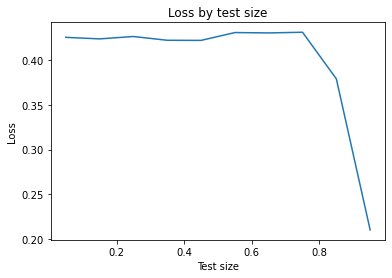

In [29]:
final_df = train_df.copy(deep = True)
t = final_df['Survived']
elem_drop = ['Survived']
x = final_df.drop(elem_drop, axis = 1)
test_size = 0.05
graph = {'Loss':[], 't':[]}
graph_df = pd.DataFrame(data=graph)
for i in range(10):
    l = loss_to_graph(x,t,test_size)
    graph_df = graph_df.append({'Loss': l, 't': test_size}, ignore_index = True)
    test_size += 0.1

display(graph_df)
plt.title('Loss by test size')
plt.ylabel('Loss')
plt.xlabel('Test size')
plt.plot(graph_df['t'], graph_df['Loss'])
plt.show()


# Analysis
We can learn from the graph that up until test_size < 0.8 the CE is in between 0.42-0.43.
When the test_size >= 0.8 we can see that the CE drops to the area of 0.2. Maybe the reason is that the modle doesn't get enough data to work with thus have less room for error.

# Final SGD with all of the features

In [30]:
final_df = train_df.copy(deep = True)
t = final_df['Survived']
elem_drop = ['Survived']
x = final_df.drop(elem_drop, axis = 1)

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=0.2, random_state=2)

t_train = train_df['Survived']
x_train = train_df.drop('Survived', axis = 1)
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train, t_train)
y_predict = SGD_cls.predict(test_df)
y_predict = y_predict.astype('int32')

submission = pd.DataFrame({'PassengerId': passenger_test_col,
                     'Survived': y_predict 
    })
submission.to_csv('submission.csv', index= False)

display(y_predict)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [31]:
final_df = train_df.copy(deep = True)
t = final_df['Survived']
elem_drop = ['Survived']
x = final_df.drop(elem_drop, axis = 1)

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(x, t, test_size=0.3, random_state=2)

t_train = train_df['Survived']
x_train = train_df.drop('Survived', axis = 1)
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train, t_train)
y_predict = SGD_cls.predict(test_df)
y_predict = y_predict.astype('int32')

submission = pd.DataFrame({'PassengerId': passenger_test_col,
                     'Survived': y_predict 
    })
submission.to_csv('submission.csv', index= False)

display(y_predict)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Leaderboard
My place 14,166th

![image](https://user-images.githubusercontent.com/59430912/99393836-99a13480-28e6-11eb-8671-344b37fbc382.png)

# Conclusion
To sum up the exercise, after loading the data and studying it, I started creating new features that could have had an influence on the survival of the passenger. 
Although not all the new features that I've added helped(the feature embarked for example, didn't play an important role in the survival of the passenger), we did see that there was a higher chance of survival if the passenger was in Pclass_1.

Source list:

1) https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#2.-Feature-Engineering

2) https://www.kaggle.com/startupsci/titanic-data-science-solutions

3)https://github.com/aviasd/Machine-Learning-Practices-Afeka-2020/blob/main/FirstPracticeML.html

4) https://github.com/aviasd/Machine-Learning-Practices-Afeka-2020/blob/main/SecondPracticeML.html